In [2]:
# 为了兼容python2和python3
from __future__ import division,print_function,unicode_literals

# 导入相应的包
import numpy as np
import pandas as pd
import os

# 为了保持稳定性一致
np.random.seed(42)

# 画图设置
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'

import warnings 
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
sns.set_style('darkgrid')                      # darkgrid,whitegrid,dark,white,ticks

In [3]:
import tensorflow as tf
print(tf.__version__)

1.8.0


# 1 梯度消失和梯度爆炸

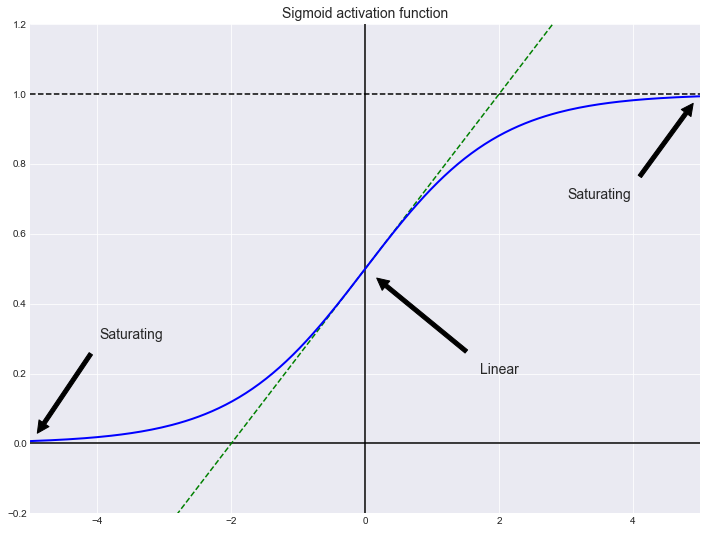

In [4]:
def logit(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.figure(figsize=[12,9])
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

# 2 非饱和激活函数

## Leaky ReLU

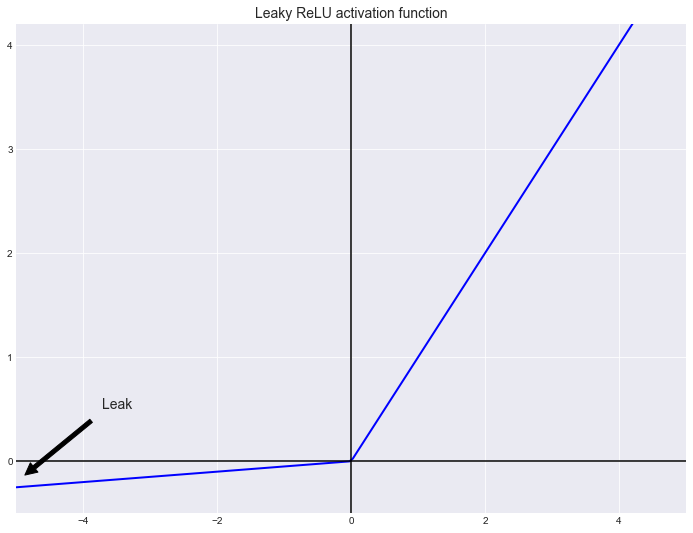

In [13]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

plt.figure(figsize=[12,9])
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

In [15]:
# Let's train a neural network on MNIST using the Leaky ReLU
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
learning_rate = 0.01
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

# 导入数据
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
mnist = loadmat('./datasets/mnist-original.mat')
X,y = mnist['data'].T,mnist['label'].T

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.reshape((len(y_train),)).astype(np.int32)
y_test = y_test.reshape((len(y_test),)).astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
        
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_dnn2.ckpt")

TypeError: unhashable type: 'numpy.ndarray'

## ELU

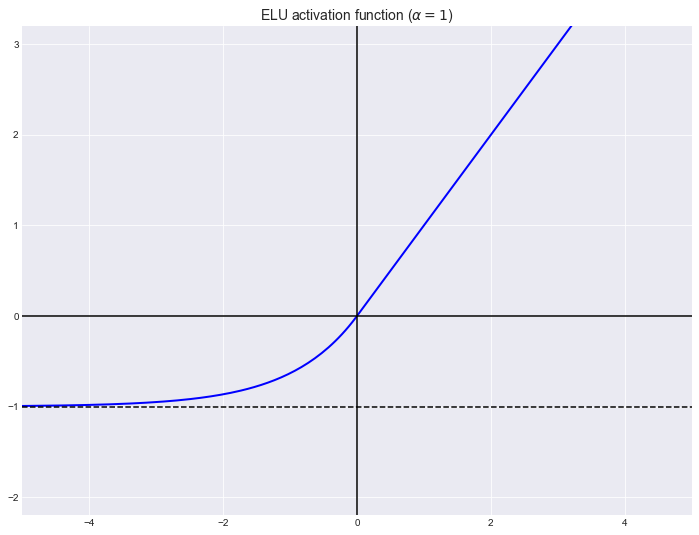

In [7]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

plt.figure(figsize=[12,9])
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

# 3 批量标准化

In [ ]:
from functools import partial
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

if __name__ == '__main__':
    n_inputs = 28 * 28
    n_hidden1 = 300
    n_hidden2 = 100
    n_outputs = 10

    mnist = input_data.read_data_sets("/tmp/data/")

    batch_norm_momentum = 0.9
    learning_rate = 0.01

    X = tf.placeholder(tf.float32, shape=(None, n_inputs), name = 'X')
    y = tf.placeholder(tf.int64, shape=None, name = 'y')
    training = tf.placeholder_with_default(False, shape=(), name = 'training')#给Batch norm加一个placeholder

    with tf.name_scope("dnn"):
        he_init = tf.contrib.layers.variance_scaling_initializer()
        #对权重的初始化

        my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training = training,
            momentum = batch_norm_momentum
        )

        my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer = he_init
        )

        hidden1 = my_dense_layer(X ,n_hidden1 ,name = 'hidden1')
        bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
        hidden2 = my_dense_layer(bn1, n_hidden2, name = 'hidden2')
        bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
        logists_before_bn = my_dense_layer(bn2, n_outputs, name = 'outputs')
        logists = my_batch_norm_layer(logists_before_bn)

    with tf.name_scope('loss'):
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits= logists)
        loss = tf.reduce_mean(xentropy, name = 'loss')

    with tf.name_scope('train'):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

    with tf.name_scope("eval"):
        correct = tf.nn.in_top_k(logists, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

    n_epoches = 20
    batch_size = 200
# 注意：由于我们使用的是 tf.layers.batch_normalization() 而不是 tf.contrib.layers.batch_norm()（如本书所述），
# 所以我们需要明确运行批量规范化所需的额外更新操作（sess.run([ training_op，extra_update_ops], ...)。
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    with tf.Session() as sess:
        init.run()
        for epoch in range(n_epoches):
            for iteraton in range(mnist.train.num_examples//batch_size):
                X_batch, y_batch = mnist.train.next_batch(batch_size)
                sess.run([training_op,extra_update_ops],
                         feed_dict={training:True, X:X_batch, y:y_batch})
            accuracy_val = accuracy.eval(feed_dict= {X:mnist.test.images,
                                                    y:mnist.test.labels})
            print(epoch, 'Test accuracy:', accuracy_val)

In [ ]:
[v.name for v in tf.trainable_variables()]

In [ ]:
[v.name for v in tf.global_variables()]